In [136]:
import tensorflow as tf

In [137]:
import numpy as np

import matplotlib as mpl
import IPython.display as display
import PIL.Image
import pathlib
from pathlib import *
from tensorflow import keras
import time
import datetime as dt
from datetime import datetime

from tensorflow.keras.preprocessing import image

In [138]:
url = 'https://www.facebook.com/photo?fbid=10210052080074420&set=pob.5108930'

In [139]:
# Here we download the image, read it into a numpy array, normalize, display, and then downsize the image to make it easier to work with.  Or not.

In [140]:
ipath = Path.cwd()
print(ipath)
fpath = ipath / 'thekidsareok.jpg'
print(type(fpath))

C:\Users\jedgo\TensorFlow\TF Tutorials\TFHub\Customization
<class 'pathlib.WindowsPath'>


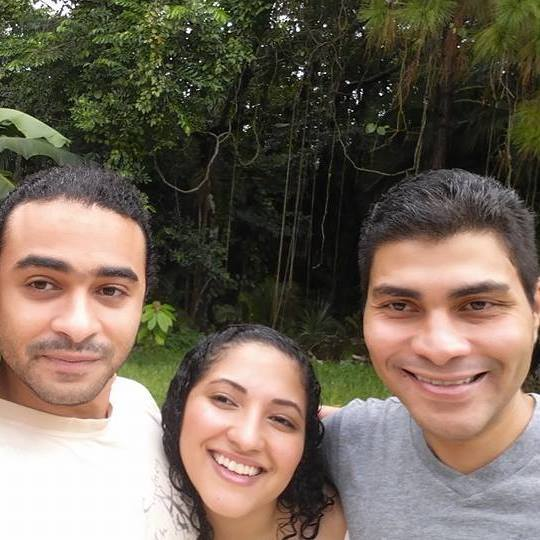

In [89]:
"""
def download(url, max_dim=540):
  name = url.split('/')[-1]
  file_name = tf.constant(['thekidsareok.jpg'])
  image_path = tf.keras.utils.get_file(name, origin=URL)
  image_path = Path.cwd()
  img = PIL.Image.open(file_name)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)
"""

def local_load(fpath, max_dim=540):
  file_name = 'thekidsareok.jpg'
  image_path = ipath
  img = PIL.Image.open(file_name)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))
  
original_img = local_load(fpath, max_dim=540)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://xenos-arcana.com">Jed-Gorman</a>'))

In [90]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [91]:
# Instead of trying to minimiize the gradient and tune the signal strength, here we're "exciting" the layers 

In [171]:
names = ['mixed0', 'mixed1', 'mixed2', 'mixed8', 'mixed9', 'mixed10']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [172]:
# Now we get to calculate the loss
def calc_loss(img, model):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if( len(layer_activations) == 1):
    layer_activations = [layer_activations]
    
  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)
    
  return tf.reduce_sum(losses)

In [173]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model
  
  @tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32),
      tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
    print("Tracing")
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        # This needs gradients relative to img, but tf.gradient watches tf variables only
        tape.watch(img)
        loss = calc_loss(img, self.model)
        
      gradients = tape.gradient(loss, img)
      
      gradients /= tf.math.reduce_std(gradients) + 1e-8
      
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)
      
    return loss, img

In [174]:
deepdream = DeepDream(dream_model)

In [175]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if (steps_remaining > 100):
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps
    
    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print('Step {}, Loss {}'.format(step, loss))
  
  
  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)
  
  return result

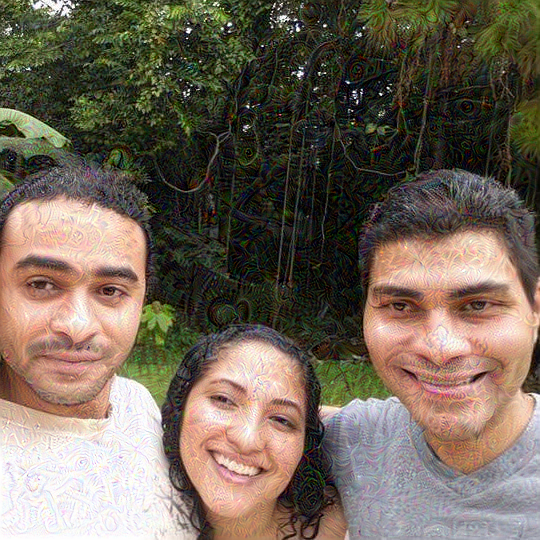

In [176]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

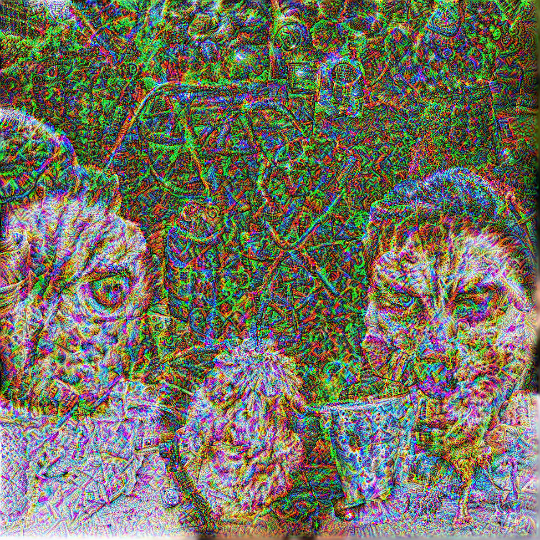

In [186]:
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-5,4):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)
  
  img = tf.image.resize(img, new_shape).numpy()
  
  img = run_deep_dream_simple(img=img, steps=50, step_size=0.05)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)
trip = PIL.Image.fromarray(np.array(img))
end = time.time()
end-start

# name = ('{} - {}'.format('trippy', dt.datetime())

safe = Path()
safe.cwd()
safe.resolve()
now = datetime.now()
datestring = now.strftime('%A, %B %d, %Y at %I %M %S %p')
trip.save('{} - {}.bmp'.format('trip', datestring))

In [178]:
def random_roll(img, maxroll):
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

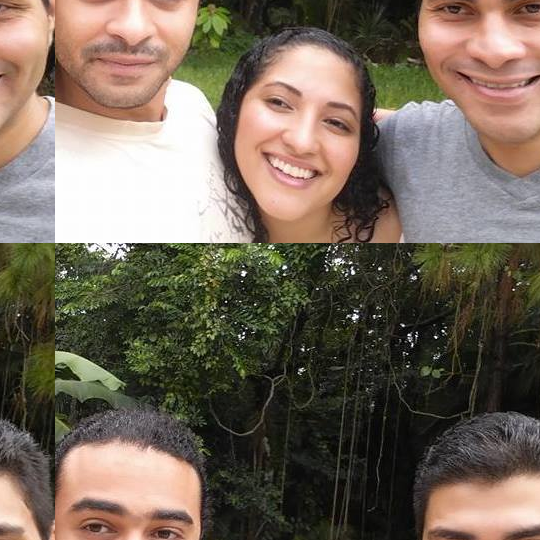

In [179]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

In [180]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model
  
  @tf.function(
    input_signature=(
      tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
      tf.TensorSpec(shape=[], dtype=tf.int32), )
  )
  def __call__(self, img, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)
    
    gradients = tf.zeros_like(img_rolled)
    
    xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])
      
    for x in xs:
      for y in ys:
        with tf.GradientTape() as tape:
          tape.watch(img_rolled)
          
          img_tile = img_rolled[x:x+tile_size, y:y+tile_size]
          loss = calc_loss(img_tile, self.model)
          
        gradients = gradients + tape.gradient(loss, img_rolled)
        
    gradients = tf.roll(gradients, shift=shift, axis=[0,1])
    
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    
    return gradients

In [181]:
get_tiled_gradients = TiledGradients(dream_model)

In [187]:
def run_deep_dream_with_octaves(img, steps_per_octave=100, step_size=0.01, octaves=range(-2,3), octave_scale=1.3):
  
  base_shape = tf.shape(img)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  
  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves: # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    img = tf.image.resize(img, tf.cast(new_size, tf.int32))
    
    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img)
      img = img + gradients * step_size
      img = tf.clip_by_value(img, -1, 1)
      
      if(step % 10 == 0):
        display.clear_output(wait=True)
        show(deprocess(img))
        print("Octave {}, Step {}".format(octave, step))
        
  result = deprocess(img)
  return result

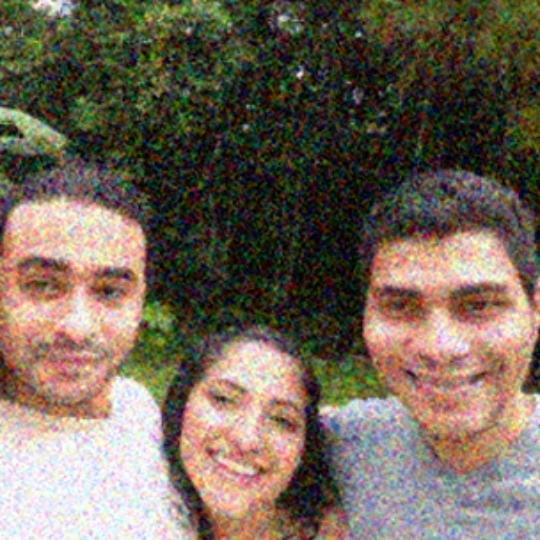

In [194]:
img = run_deep_dream_with_octaves(img=original_img, steps_per_octave=100, step_size=0.01, octaves=range(-8,-5), octave_scale=1.1)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

trip = PIL.Image.fromarray(np.array(img))
safe = Path()
safe.cwd()
safe.resolve()
now = datetime.now()
datestring = now.strftime('%A, %B %d, %Y at %I %M %S %p')
trip.save('{} - {}.bmp'.format('advanced-trip', datestring))